# Download and Unzip Preprocessed Dataset

In [1]:
# need latest gdown if on google colab
!pip install --upgrade --no-cache-dir gdown

# download images
!gdown --id 16lu4ajCmcWp_ZZenCWaoC8JquONGw_S3

# download annotations
!gdown --id 12PEn1KL4dCyvSAtUT1eD6WoAEGpiYZrA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16lu4ajCmcWp_ZZenCWaoC8JquONGw_S3
To: /content/RUGD_dataset_conv.zip
100% 638M/638M [00:01<00:00, 340MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12PEn1KL4dCyvSAtUT1eD6WoAEGpiYZrA
To: /content/RUGD_labels_conv.zip
100% 234M/234M [00:00<00:00, 301MB/s]


In [2]:
!unzip "RUGD_labels_conv.zip"
!unzip "RUGD_dataset_conv.zip"

Streaming output truncated to the last 5000 lines.
  inflating: RUGD_dataset_conv/train/trail-15_00621.jpg  
  inflating: RUGD_dataset_conv/train/trail-12_00621.jpg  
  inflating: RUGD_dataset_conv/train/trail-4_03041.jpg  
  inflating: RUGD_dataset_conv/train/trail-5_00971.jpg  
  inflating: RUGD_dataset_conv/train/trail-3_01626.jpg  
  inflating: RUGD_dataset_conv/train/trail-3_00906.jpg  
  inflating: RUGD_dataset_conv/train/trail_02196.jpg  
  inflating: RUGD_dataset_conv/train/trail-5_01246.jpg  
  inflating: RUGD_dataset_conv/train/trail_02136.jpg  
  inflating: RUGD_dataset_conv/train/creek_03871.jpg  
  inflating: RUGD_dataset_conv/train/trail-4_02301.jpg  
  inflating: RUGD_dataset_conv/train/creek_03571.jpg  
  inflating: RUGD_dataset_conv/train/trail-14_01031.jpg  
  inflating: RUGD_dataset_conv/train/creek_02211.jpg  
  inflating: RUGD_dataset_conv/train/creek_00441.jpg  
  inflating: RUGD_dataset_conv/train/trail-5_01056.jpg  
  inflating: RUGD_dataset_conv/train/village_0

# Setup and Install Detectron2

In [3]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

#!pip uninstall torch
#!pip install torch==1.10.0 torchvision==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 33.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=a03595d79a5cde4ed6ffe6a407ba517a9b439f9889decf4f3d4f9ece997c2bca
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7ymcttpn
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7ymcttpn
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 79 kB

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.11 ; cuda:  cu113
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_panoptic_separated


# Panoptic Quality Evaluation - Baseline Reference
We will evaluate the performance of a baseline Detectron2 panoptic segmentation model (panoptic_fpn_R_50_1x.yaml) running on the RUGD test dataset / Rellis test dataset by using the Panoptic Quality metric.

Afterwards, we will train the Detectron2 panoptic segmentation model with the RUGD training dataset / Rellis training dataset, and again evaluate the performance of the fine-tuned Detectron2 panoptic segmentation model on the RUGD test dataset / Rellis test dataset by using the Panoptic Quality metric.

# Panoptic Quality Method 1
With the first method, we will try to use the built-in Detectron2 "COCOPanopticEvaluator" class to do both inference and evaluation on our test dataset. 

This requires our test dataset to be registered with the correct metadata set. COCOPanopticEvaluator uses the COCO Panoptic API Evaluation script (https://github.com/cocodataset/panopticapi) to generate the panoptic quality score of the test dataset (after the inference is done).

## Register Our Dataset
Register our RUGD Preprocessed Test Dataset

In [7]:
register_coco_panoptic_separated(
    "RUGD_test", 
    {}, 
    "RUGD_dataset_conv/test", 
    "RUGD_labels/panoptic_test", 
    "RUGD_labels/annotations_test_panoptic.json", 
    "RUGD_labels/test_semantic", 
    "RUGD_labels/annotations_test_instances.json")

## Set Metadata Information
Set the Metadata information required for COCOPanopticEvaluator

In [8]:
# Initial metadata from registering the test set

metadata = MetadataCatalog.get("RUGD_test_separated")
metadata

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='RUGD_dataset_conv/test', json_file='RUGD_labels/annotations_test_instances.json', name='RUGD_test_separated', panoptic_json='RUGD_labels/annotations_test_panoptic.json', panoptic_root='RUGD_labels/panoptic_test', sem_seg_root='RUGD_labels/test_semantic')

In [9]:
# Manually set the things and stuff

# things = ['pole', 'vehicle', 'log', 'bicycle', 'person', 'picnic-table']

# stuffs = ['void', 'dirt', 'sand', 'grass', 'tree', 'water', 'sky', 'generic-object', 'asphalt', 'gravel', 'building', 'mulch', 'rock-bed', 'fence',
#           'bush', 'sign', 'rock', 'bridge', 'concrete']

# MetadataCatalog.get("RUGD_test_separated").set(thing_classes=things, stuff_classes=stuffs)

Set metadata using categories.json

In [10]:
import json

with open("RUGD_labels/categories.json") as json_file: 
  categories = json.load(json_file) 

In [11]:
things = [f["name"] for f in categories if f["isthing"] == 1]
thing_ids = [f["id"] for f in categories if f["isthing"] == 1]
stuffs = [f["name"] for f in categories if f["isthing"] == 0]
stuff_ids = [f["id"] for f in categories if f["isthing"] == 0]
stuff_dataset_id_to_contiguous_id = dict(zip(stuff_ids,list(range(0,len(stuff_ids)))))
thing_dataset_id_to_contiguous_id = dict(zip(thing_ids, list(range(0,len(thing_ids)))))

MetadataCatalog.get("RUGD_test_separated").set(thing_classes=things, stuff_classes=stuffs, stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id, thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id)

#dataset_dicts = DatasetCatalog.get("RUGD_test_separated")

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='RUGD_dataset_conv/test', json_file='RUGD_labels/annotations_test_instances.json', name='RUGD_test_separated', panoptic_json='RUGD_labels/annotations_test_panoptic.json', panoptic_root='RUGD_labels/panoptic_test', sem_seg_root='RUGD_labels/test_semantic', stuff_classes=['dirt', 'sand', 'grass', 'tree', 'water', 'sky', 'generic-object', 'asphalt', 'gravel', 'building', 'mulch', 'rock-bed', 'fence', 'bush', 'sign', 'rock', 'bridge', 'concrete'], stuff_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 9: 6, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17}, thing_classes=['pole', 'vehicle', 'log', 'bicycle', 'person', 'picnic-table'], thing_dataset_id_to_contiguous_id={5: 0, 8: 1, 15: 2, 16: 3, 17: 4, 24: 5})

## Import Model
Import the baseline Detectron2 Panoptic Segmentation model : panoptic_fpn_R_50_1x.yaml

In [12]:
# Baseline Panoptic Segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set threshold to 0.7
predictor = DefaultPredictor(cfg)

model_final_dbfeb4.pkl: 184MB [00:04, 38.6MB/s]                           


## COCOPanopticEvaluator
Use COCOPanopticEvaluator class to do both inference and Panoptic Quality evaluation on our test dataset.

In [13]:
# Panoptic Quality Evaluation along with Inference

from detectron2.evaluation import COCOPanopticEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOPanopticEvaluator("RUGD_test_separated", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "RUGD_test_separated")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

AssertionError: ignored

# Panoptic Quality Method 2
With the second method, we will try to use the COCO Panoptic API (https://github.com/cocodataset/panopticapi/blob/master/README.md) directly in order to evaluate with Panoptic Quality.

## Install COCODataset PanopticAPI

In [14]:
!pip install git+https://github.com/cocodataset/panopticapi.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-sf5e5xat
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-sf5e5xat
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=9b8d21c7beb43fdadf9146ea23b9335642bd4aaa76a944b0f2506d1fc66fa5e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_nwfonh1/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


In [15]:
!python -m panopticapi.evaluation --help

usage: evaluation.py [-h] [--gt_json_file GT_JSON_FILE]
                     [--pred_json_file PRED_JSON_FILE] [--gt_folder GT_FOLDER]
                     [--pred_folder PRED_FOLDER]

optional arguments:
  -h, --help            show this help message and exit
  --gt_json_file GT_JSON_FILE
                        JSON file with ground truth data
  --pred_json_file PRED_JSON_FILE
                        JSON file with predictions data
  --gt_folder GT_FOLDER
                        Folder with ground turth COCO format segmentations.
                        Default: X if the corresponding json file is X.json
  --pred_folder PRED_FOLDER
                        Folder with prediction COCO format segmentations.
                        Default: X if the corresponding json file is X.json


In [16]:
# Find installation path of panopticapi script

!ls /usr/local/lib/python3.7/dist-packages/panopticapi

combine_semantic_and_instance_predictions.py  __init__.py  utils.py
evaluation.py				      __pycache__


In [17]:
# Test run the evaluation script with ground truth to ground truth comparison

!python /usr/local/lib/python3.7/dist-packages/panopticapi/evaluation.py --gt_json_file /content/RUGD_labels/annotations_test_panoptic.json --pred_json_file /content/RUGD_labels/annotations_test_panoptic.json --gt_folder /content/RUGD_labels/test_panoptic --pred_folder /content/RUGD_labels/test_panoptic

Evaluation panoptic segmentation metrics:
Ground truth:
	Segmentation folder: /content/RUGD_labels/test_panoptic
	JSON file: /content/RUGD_labels/annotations_test_panoptic.json
Prediction:
	Segmentation folder: /content/RUGD_labels/test_panoptic
	JSON file: /content/RUGD_labels/annotations_test_panoptic.json
Number of cores: 2, images per core: 372
Core: 1, 0 from 372 images processed
Core: 0, 0 from 372 images processed
Core: 1, 100 from 372 images processed
Core: 0, 100 from 372 images processed
Core: 0, 200 from 372 images processed
Core: 1, 200 from 372 images processed
Core: 0, 300 from 372 images processed
Core: 1, 300 from 372 images processed
Core: 0, all 372 images processed
Core: 1, all 372 images processed
          |    PQ     SQ     RQ     N
--------------------------------------
All       | 100.0  100.0  100.0    24
Things    | 100.0  100.0  100.0     6
Stuff     | 100.0  100.0  100.0    18
Time elapsed: 21.64 seconds


If we can retrieve the JSON annotation file as well as the PNG images in COCO format from the Detectron2 model predictions on our test dataset, we would be able to directly use PanopticAPI as above in order to get our evaluation scores.

## Exploring Inferencing outputs

In [18]:
# Inference with the baseline panoptic segmentation model

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml")
predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/RUGD_dataset_conv/test/creek_00316.jpg")
outputs = predictor(im)["panoptic_seg"]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


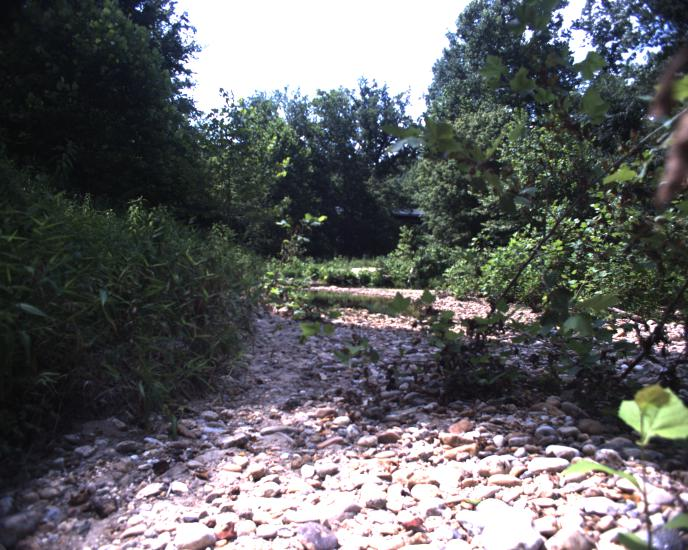

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(im)

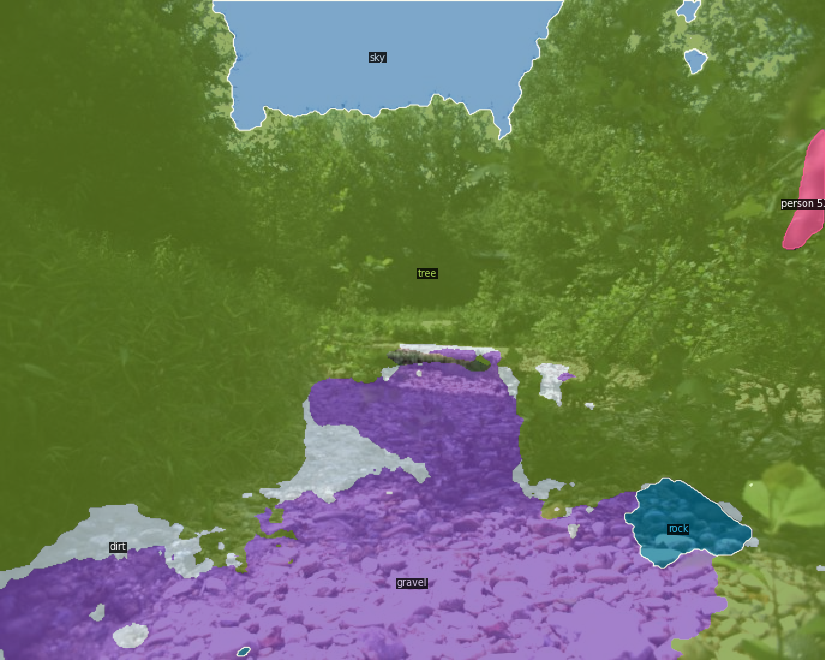

In [20]:
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [21]:
panoptic_seg.shape

torch.Size([550, 688])

In [22]:
# This is still not all the information needed in JSON annotation file

segments_info

[{'area': 1952.0,
  'category_id': 0,
  'id': 1,
  'instance_id': 0,
  'isthing': True,
  'score': 0.534930408000946},
 {'area': 77860.0, 'category_id': 11, 'id': 2, 'isthing': False},
 {'area': 256258.0, 'category_id': 37, 'id': 3, 'isthing': False},
 {'area': 24696.0, 'category_id': 40, 'id': 4, 'isthing': False},
 {'area': 11980.0, 'category_id': 47, 'id': 5, 'isthing': False},
 {'area': 4941.0, 'category_id': 51, 'id': 6, 'isthing': False}]